## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.figsize'] = (15, 5)

In [4]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [5]:
%run ../utils/__init__.py

## Load data

In [5]:
%run ../datasets/__init__.py

### Load seg dataset

In [6]:
kwargs = {
    'dataset_name': 'jsrt',
    'dataset_type': 'test',
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}
jsrt_dataloader = prepare_data_segmentation(**kwargs)
len(jsrt_dataloader.dataset)

62

In [7]:
jsrt_dataloader.dataset.__class__.__name__

'JSRTDataset'

In [8]:
item = jsrt_dataloader.dataset[1]
item.image.size()

torch.Size([1, 1024, 1024])

(-0.5, 1023.5, 1023.5, -0.5)

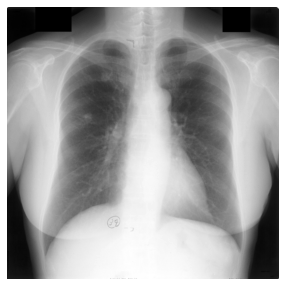

In [10]:
plt.imshow(item.image[0], cmap='gray')
plt.axis('off')

### Load IU x-ray

In [9]:
kwargs = {
    'dataset_name': 'iu-x-ray',
    'dataset_type': 'all',
    'batch_size': 10,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

iu_dataloader = prepare_data_classification(**kwargs)
len(iu_dataloader.dataset)

3800

In [12]:
item = iu_dataloader.dataset[1]
item.image.size()

torch.Size([1, 1024, 1024])

(-0.5, 1023.5, 1023.5, -0.5)

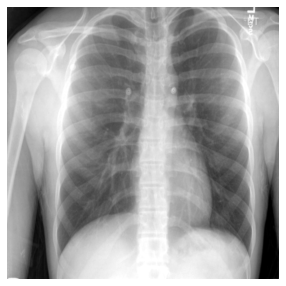

In [13]:
plt.imshow(item.image[0], cmap='gray')
plt.axis('off')

### Load CXR-14

In [ ]:
kwargs = {
    'dataset_name': 'cxr14',
    'dataset_type': 'train',
    'batch_size': 10,
    'image_format': 'L',
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

cxr14_dataloader = prepare_data_classification(**kwargs)
len(cxr14_dataloader.dataset)

### Covid-UC

In [ ]:
kwargs = {
    'dataset_name': 'covid-uc',
    'dataset_type': 'train',
    'batch_size': 10,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

coviduc_dataloader = prepare_data_classification(**kwargs)
len(coviduc_dataloader.dataset)

## Load model

In [10]:
%run ../models/checkpoint/__init__.py

In [11]:
run_names = [
#     '1105_180035_jsrt_scan_lr0.0001_normD_size1024',
#     '1106_092037_jsrt_scan_lr0.0001_normD_size1024',
    # '1106_180455_jsrt_scan_lr0.0005_normS_size1024_wce1-4-3-3_sch-iou-p5-f0.2',
    '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5',
]
debug = False

# run_name = '1106_165046_jsrt_scan_lr0.0001_normS_size1024_wce1-4-3-3'
# run_name = '1106_174749_jsrt_scan_lr0.0001_normS_size1024_wce1-4-3-3'
# run_name = '1106_175002_jsrt_scan_lr0.0001_normS_size1024_wce1-4-3-3'
# debug = True

In [12]:
compiled_models = [
    load_compiled_model_segmentation(run_name, debug=debug, device=DEVICE)
    for run_name in run_names
]

In [22]:
compiled_models[0].metadata

{'model_kwargs': {'model_name': 'scan', 'n_classes': 4},
 'opt_kwargs': {'lr': 0.0005},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.5,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_weights': [0.1, 0.6, 0.3, 0.3],
  'early_stopping': True,
  'early_stopping_kwargs': {'patience': 20, 'metric': 'iou', 'min_delta': 0},
  'lr_sch_metric': 'iou'},
 'dataset_kwargs': {'dataset_name': 'jsrt',
  'batch_size': 20,
  'image_size': [1024, 1024],
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None,
  'augment': True,
  'augment_label': None,
  'augment_class': None,
  'augment_times': 10,
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.8,
   'brightness': 0.8,
   'shear': [10, 10]}},
 'run_name': '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'}

## Plot segmentation examples

### Functions

In [ ]:
import re

In [ ]:
%run ../utils/nlp.py

In [ ]:
def calculate_output(model, item):
    images = item.image.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(images)

    outputs = outputs.squeeze(0)
    _, outputs = outputs.max(dim=0)
    outputs = outputs.detach().cpu().numpy() # height, width
    
    return outputs

In [ ]:
def print_report(dataloader, idx):
    dataset = dataloader.dataset
    item = dataset[idx]
    
    report_reader = ReportReader(dataset.get_vocab())
    
    report = report_reader.idx_to_text(item.report)
    
    print(report)

In [ ]:
def shorter_name(run_name):
    group = re.search(r'\d{4}_\d{6}', run_name)
    if group:
        return group[0]
    return run_name

In [ ]:
def plot_example(compiled_models, dataloader, sample_idx, titlesize=15):
    dataset = dataloader.dataset
    item = dataset[sample_idx]
    
    if not isinstance(compiled_models, (tuple, list)):
        compiled_models = (compiled_models,)

    outputs = [
        (
            compiled_model.metadata.get('run_name'),
            calculate_output(compiled_model.model, item),
        )
        for compiled_model in compiled_models
    ]
    
    n_cols = 1 + len(outputs)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, n_cols, 1)
    dataset_name = dataset.__class__.__name__.lower().strip('dataset')
    title = f'{dataset_name}, sample={sample_idx}'
    if dataset.__class__.__name__ == 'JSRTDataset':
        title += f', {dataset.dataset_type}'
    plt.title(title, fontsize=titlesize)
    plt.imshow(item.image[0], cmap='gray')
    plt.axis('off')

    for index, (run_name, output) in enumerate(outputs):
        print(run_name)
        plt.subplot(1, n_cols, index + 2)
        plt.title(shorter_name(run_name), fontsize=titlesize)
        plt.imshow(output)
        plt.axis('off')

### JSRT examples

In [ ]:
plot_example(jsrt_dataloader, 0)

In [ ]:
plot_example(jsrt_dataloader, 3)

In [ ]:
plot_example(jsrt_dataloader, 20)

In [ ]:
plot_example(jsrt_dataloader, 1, titlesize=25)

### IU x-ray dataset

In [ ]:
idx = 2
print_report(iu_dataloader, idx)
plot_example(compiled_models, iu_dataloader, idx, titlesize=20)

In [ ]:
idx = 300
print_report(iu_dataloader, idx)
plot_example(compiled_models, iu_dataloader, idx, titlesize=20)

In [ ]:
idx = -50
print_report(iu_dataloader, idx)
plot_example(compiled_models, iu_dataloader, idx, titlesize=20)

In [ ]:
idx = 740
print_report(iu_dataloader, idx)
plot_example(compiled_models, iu_dataloader, idx)

### CXR-14 examples

In [ ]:
plot_example(cxr14_dataloader, 0, titlesize=25)

In [ ]:
plot_example(cxr14_dataloader, 20, titlesize=25)

In [ ]:
plot_example(cxr14_dataloader, 50)

### Covid-UC

In [ ]:
plot_example(coviduc_dataloader, 2)

In [ ]:
plot_example(coviduc_dataloader, 15)

In [ ]:
plot_example(coviduc_dataloader, 6)

In [ ]:
coviduc_dataloader.dataset._metadata_df.iloc[1]

## Clean polygons

### Functions

In [13]:
from collections import defaultdict
import mahotas.polygon
import rasterio.features
from shapely.geometry import Polygon

In [14]:
%run ../metrics/segmentation/shapes/metric.py
%run ../utils/shapes.py

In [15]:
compiled_model = compiled_models[0]
model = compiled_model.model
compiled_model.metadata['model_kwargs']

{'model_name': 'scan', 'n_classes': 4}

In [16]:
iu_dataset = iu_dataloader.dataset
jsrt_dataset = jsrt_dataloader.dataset
len(jsrt_dataset), len(iu_dataset)

(62, 3800)

In [17]:
def calculate_mask(item):
    images = item.image.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(images)

    outputs = outputs.squeeze(0)
    _, outputs = outputs.max(dim=0)
    outputs = outputs.detach().cpu() # height, width
    
    return outputs

In [20]:
def plot_example(dataset, sample_idx):
    item = dataset[sample_idx]

    mask = calculate_mask(item)
    polygons = calculate_polygons(mask)
    largest_polygons = get_largest_shapes(polygons)
    clean_arr = polygons_to_array(largest_polygons, tuple(mask.size()))
    
    ## Plots
    n_cols = 5
    n_rows = 1

    gt_mask = item.masks
    if isinstance(gt_mask, torch.Tensor):
        n_cols += 1
        plt.subplot(n_rows, n_cols, n_rows * n_cols)
        plt.title('GT')
        plt.imshow(gt_mask)
        plt.axis('off')

    # Plot original x-ray
    plt.subplot(n_rows, n_cols, 1)
    plt.title('X-ray')
    plt.imshow(item.image[0], cmap='gray')
    # plt.axis('off')

    # Plot prediction
    plt.subplot(n_rows, n_cols, 2)
    plt.title('Predicted')
    plt.imshow(mask)
    # plt.axis('off')

    # Plot shapes from prediction
    plt.subplot(n_rows, n_cols, 3)
    plt.axis('scaled')
    plt.title('Shapes')
    plt.ylim(0, mask.size(0))
    plt.xlim(0, mask.size(1))
    plt.gca().invert_yaxis()
    for polygon, organ_idx in polygons:
        for coords in polygon:
            x_values, y_values = zip(*coords)
            plt.plot(x_values, y_values, label=int(organ_idx))

    # Plot clean shapes
    plt.subplot(n_rows, n_cols, 4)
    plt.axis('scaled')
    plt.title('Clean shapes')
    plt.ylim(0, mask.size(0))
    plt.xlim(0, mask.size(1))
    plt.gca().invert_yaxis()
    for coords, organ_idx in largest_polygons:
        x_values, y_values = zip(*coords)
        plt.plot(x_values, y_values)
        
    # Plot clean shapes as arr
    plt.subplot(n_rows, n_cols, 5)
    plt.title('Clean arr')
    plt.imshow(clean_arr)
    
    return mask, clean_arr

### Plot some examples

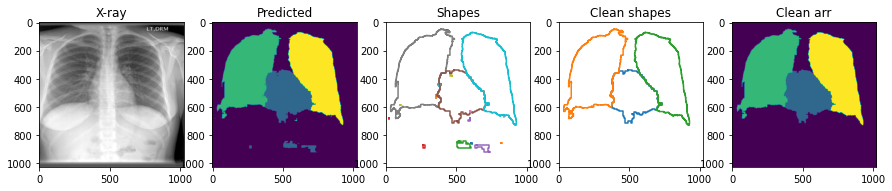

In [22]:
mask, clean_arr = plot_example(iu_dataset, 2)

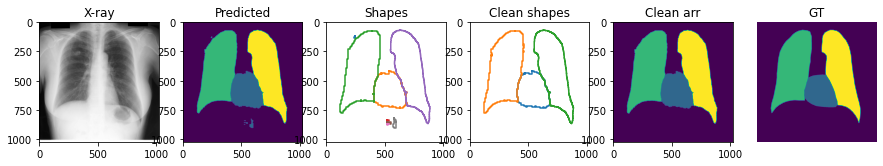

In [23]:
mask, clean_arr = plot_example(jsrt_dataset, 2)

In [142]:
jsrt_dataset.seg_labels

['background', 'heart', 'right lung', 'left lung']

In [24]:
m = OrganShapesAndHolesMetric(ignore=0)
m.update(mask.unsqueeze(0))
m.compute()

{'n-shapes': {2: 2.0, 1: 5.0, 3: 1.0}, 'n-holes': {2: 0.0, 1: 0.0, 3: 0.0}}